# Portada
Avance de proyecto 1: Sistema de Recomendación

- Leonardo Seguraa01176833
- Esteban Hidekel Solares Orozcoa01657027
- Diego Armando Ayala Hernández a01376727

Análisis de grandes volúmenes de datos (Gpo 10)

Github: https://github.com/DiegoAyalaH/ProyectoBigData

# Plan de proyecto

## Acuerdo con el profesor
- No se han hecho visibles las entregas futuras, por lo que plantearemos el plan de proyecto de forma genérica, como se acordó con el profesor en la clase.
- https://youtu.be/tB0fjBeT_mc?si=gq6jhXr-m6mDq6Oj&t=3740

## Cronograma

**Etapa 1: Definiendo el problema y el caso de negocio**
- Identificar claramente el problema a resolver y establecer los objetivos del proyecto. Desarrollar un caso de negocio que justifique la inversión y los beneficios esperados.
- **Fecha pendiente**

**Etapa 2: Identificación y adquisición de datos**
- Determinar qué datos son necesarios para el análisis y cómo se obtendrán. Esto incluye la recolección de datos de diversas fuentes, asegurando su calidad y relevancia.
- **Fecha pendiente**

**Etapa 3: Extracción y filtración de datos**
- Extraer los datos necesarios de las fuentes identificadas y aplicar filtros para eliminar información irrelevante o incorrecta.
- **Fecha pendiente**

**Etapa 4: Preprocesamiento y transformación de datos**
- Limpiar y transformar los datos para que sean utilizables en el análisis. Esto puede incluir la normalización, la imputación de valores faltantes y la conversión de formatos.
- **Fecha pendiente**

**Etapa 5: Análisis exploratorio de datos**
- Examinar los datos a través de técnicas estadísticas y visualizaciones iniciales para comprender su estructura, patrones y relaciones.
- **Fecha pendiente**

**Etapa 6: Visualización de datos**
- Crear gráficos y visualizaciones que representen los datos de manera clara y comprensible, facilitando la identificación de tendencias y patrones.
- **Fecha pendiente**

**Etapa 7: Análisis y modelación de datos**
- Aplicar técnicas analíticas y modelos matemáticos para obtener insights y predecir comportamientos futuros. Esto puede incluir análisis estadísticos, machine learning, y más.
- **Fecha pendiente**

**Etapa 8: Informes y comunicación**
- Documentar los hallazgos y presentarlos de manera comprensible a las partes interesadas. Los informes deben incluir visualizaciones y explicaciones claras de los resultados.
- **Fecha pendiente**

**Etapa 9: Gobernanza de datos**
- Implementar políticas y procedimientos para garantizar la calidad, integridad, seguridad y uso adecuado de los datos a lo largo del tiempo.
- **Fecha pendiente**




# Código

## Librerías y configuración

In [ ]:
# Instalar surprise
!pip install surprise

In [ ]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Montamos Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path de carpeta de proyecto
drivepath = "/content/drive/MyDrive/4034 Big Data/4034 Big Data Equipo 4/Recomendaciones libros/"

## Pre-procesamiento y transformacione
En esta libreta, hemos seleccionado un conjunto de datos de calificaciones de libros, ya que es ideal para construir y evaluar sistemas de recomendación. Este tipo de sistemas es fundamental en la industria del comercio electrónico y entretenimiento, donde personalizan la experiencia del usuario.

Comenzamos importando las bibliotecas necesarias y leyendo los conjuntos de datos de libros, calificaciones y usuarios. Luego, fusionamos las calificaciones con la información de los libros y eliminamos las columnas de imágenes, ya que no son necesarias para nuestro análisis. Renombramos las columnas para mayor claridad y iltramos los usuarios que han dado al menos 50 calificaciones y los libros que han recibido al menos 10 calificaciones para asegurar suficiente variabilidad.


In [ ]:
# Leer los conjuntos de datos
libros = pd.read_csv(drivepath+"Books.csv")
calificaciones = pd.read_csv(drivepath+"Ratings.csv")
usuarios = pd.read_csv(drivepath+"Users.csv")

# Fusionar conjuntos de datos de calificaciones y libros
df = pd.merge(calificaciones, libros.drop_duplicates(['ISBN']), on="ISBN", how="left")
df.drop(['Image-URL-S','Image-URL-M','Image-URL-L'], axis=1, inplace=True)

# Renombrar columnas
df.rename(columns={'User-ID':'user_id', 'ISBN':'book_id', 'Book-Rating':'rating'}, inplace=True)
df['book_id'] = df['book_id'].astype(str)

# Filtrar usuarios con al menos 50 calificaciones y libros con al menos 10 calificaciones
limite_calificaciones_usuario = 50
limite_calificaciones_libro = 10

conteo_calificaciones_usuario = df['user_id'].value_counts()
conteo_calificaciones_libro = df['book_id'].value_counts()

usuarios_a_eliminar = conteo_calificaciones_usuario[conteo_calificaciones_usuario < limite_calificaciones_usuario].index
libros_a_eliminar = conteo_calificaciones_libro[conteo_calificaciones_libro < limite_calificaciones_libro].index

df = df[~df['user_id'].isin(usuarios_a_eliminar)]
df = df[~df['book_id'].isin(libros_a_eliminar)]


## Análisis exploratorio
En la sección de análisis exploratorio, primero mostramos las primeras filas del conjunto de datos para tener una visión general de su estructura y contenido. Luego, verificamos la distribución de las calificaciones utilizando un gráfico de barras. Esto nos ayuda a entender cómo se distribuyen las calificaciones en el conjunto de datos, identificando posibles sesgos o patrones que  podrían influir en el rendimiento del modelo de recomendación.

Eliminamos las calificaciones con valor 0, ya que no representan una calificación válida sino la ausencia de una. Podemos ver que la calificación de 8 es la más común (a excepción de la falta de calificación).

In [ ]:
# Mostrar las primeras filas del conjunto de datos
df.head()

,user_id,book_id,rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
173,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books
174,276847,3257200552,5,NaN,NaN,NaN,NaN
175,276847,3379015180,0,Schlafes Bruder,Robert Schneider,1994,"Reclam, Leipzig"
177,276847,3404148576,8,Nordermoor,Arnaldur Indridason,2003,LÃ?Â¼bbe
179,276847,3423071516,10,Der Kleine Hobbit,J. R. R. Tolkien,2002,Distribooks


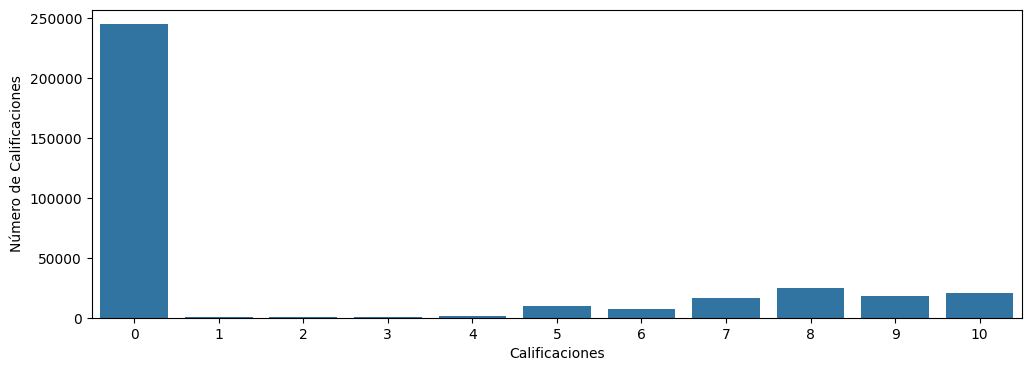

In [ ]:
# Verificar la distribución de calificaciones
plt.figure(figsize=(12, 4))
sns.countplot(x="rating", data=df)
plt.xlabel("Calificaciones")
plt.ylabel("Número de Calificaciones")
plt.show()

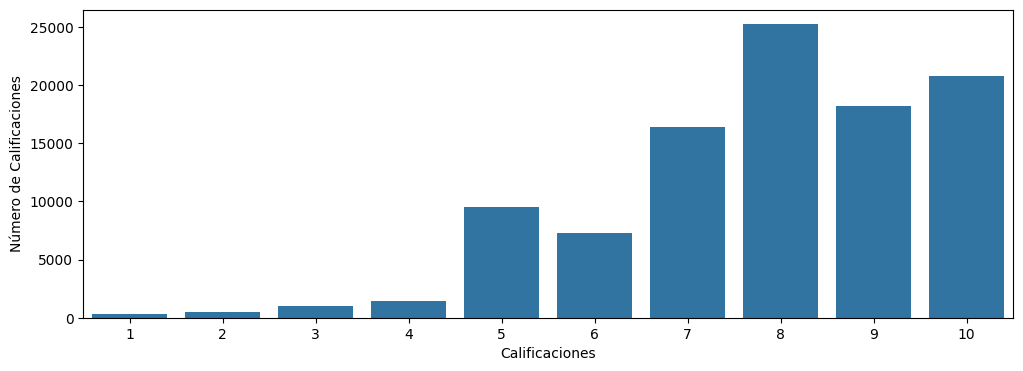

In [ ]:
# Eliminar calificaciones de 0
df = df[df['rating'] != 0]

# Verificar la distribución de calificaciones
plt.figure(figsize=(12, 4))
sns.countplot(x="rating", data=df)
plt.xlabel("Calificaciones")
plt.ylabel("Número de Calificaciones")
plt.show()

## Codificado
Para preparar los datos para el modelo, codificamos las columnas user_id y book_id utilizando LabelEncoder, lo cual transforma  los identificadores en un formato numérico necesario para el modelo. Luego, utilizamos la clase Reader de la biblioteca surprise  para definir la escala de calificación esperada y cargar el conjunto de datos en el formato requerido por surprise. Dividimos  los datos en conjuntos de entrenamiento y prueba para evaluar el modelo de manera adecuada.


In [ ]:
# Codificar user_id y book_id
encoder = LabelEncoder()
datos = df[['user_id', 'book_id']].apply(encoder.fit_transform)
datos['rating'] = df['rating']

# Preparar el conjunto de datos para la biblioteca surprise
lector = Reader(rating_scale=(1, 10))
dataset_surprise = Dataset.load_from_df(datos[['user_id', 'book_id', 'rating']], lector)

# Dividir los datos en conjuntos de entrenamiento y prueba
trainset, testset = train_test_split(dataset_surprise, test_size=0.3, random_state=42)

## Algoritmo básico (KNN basado en similitud de coseno)
En esta sección, implementamos el modelo de recomendación básico utilizando KNN basado en la similitud del coseno. Definimos las opciones de similitud sin el parámetro min_support para evitar problemas con vecinos insuficientes. Entrenamos el algoritmo en  el conjunto de entrenamiento y luego evaluamos su rendimiento en el conjunto de prueba. Utilizamos métricas de precisión, recall  y F1-score para evaluar la calidad de las recomendaciones.


In [ ]:
# Definir las opciones de similitud con min_support
sim_options = {'name': 'cosine', 'user_based': True}

# Crear el algoritmo KNN básico
algo_knn_user = KNNBasic(sim_options=sim_options, verbose=False)

# Entrenar el algoritmo en el conjunto de entrenamiento
algo_knn_user.fit(trainset)

## Evaluación
Para evaluar el modelo, definimos una función precision_recall_at_k que calcula la precisión, el recall y la puntuación F1. Esta función agrupa las predicciones por usuario, ordena las calificaciones estimadas y calcula las métricas en función de un umbral definido. Imprimimos las métricas calculadas y utilizamos la función rmse de surprise para calcular el error cuadrático medio de las predicciones. Esto nos proporciona una visión completa del rendimiento del modelo.

Los resultados muestran un RMSE de 1.9551, lo que indica la desviación promedio de las calificaciones predichas respecto a las calificaciones reales. La precisión es de 0.794, lo que significa que el 79.4% de las recomendaciones fueron relevantes. El recall es de 0.787, lo que indica que el 78.7% de los ítems relevantes fueron recomendados. La puntuación F1, que es una medida combinada de precisión y recall, es de 0.79.

In [ ]:
# Función para calcular precisión, recall y F1-score
def precision_recall_at_k(model, k=10, threshold=7):
    # Diccionario para almacenar las predicciones de cada usuario
    user_est_true = defaultdict(list)
    # Obtener predicciones para el conjunto de prueba
    predictions = model.test(testset)
    # Agrupar las predicciones por usuario
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    # Calcular precisión y recall para cada usuario
    for uid, user_ratings in user_est_true.items():
        # Ordenar las calificaciones del usuario por el valor estimado
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Número de ítems relevantes
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # Número de ítems recomendados en el top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        # Número de ítems relevantes y recomendados en el top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        # Precisión@K: Proporción de ítems recomendados que son relevantes
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # Recall@K: Proporción de ítems relevantes que son recomendados
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    # Calcular la media de todas las precisiones predichas
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    # Calcular la media de todos los recalls predichos
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    # Calcular RMSE
    accuracy.rmse(predictions)
    # Imprimir precisión, recall y F1-score
    print('Precisión: ', precision)
    print('Recall: ', recall)
    print('Puntuación F_1: ', round((2*precision*recall)/(precision+recall), 3))

# Calcular precisión, recall y F1-score
precision_recall_at_k(algo_knn_user)


RMSE: 1.9551
Precisión:  0.794
Recall:  0.787
Puntuación F_1:  0.79


## Predicción

In [ ]:
# Predecir la calificación para un usuario y un libro específico
algo_knn_user.predict(69, 420, r_ui=None, verbose=True)

user: 69         item: 420        r_ui = None   est = 10.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=69, iid=420, r_ui=None, est=10, details={'actual_k': 1, 'was_impossible': False})

Finalmente, realizamos una predicción específica para un usuario y un libro, utilizando el modelo entrenado. Esto nos permite ver una predicción real y evaluar cómo el modelo maneja casos específicos. Esta predicción se compara con una calificación real (si está disponible) o se estima una nueva calificación. Esta sección demuestra la aplicabilidad práctica del modelo de recomendación.

En este caso, la predicción para el usuario con ID 69 y el libro con ID 420 es una calificación estimada de 10.00. Esto indica que el modelo predice que este usuario otorgará una calificación alta a este libro.


In [ ]:
# Definir los parámetros
x = 10  # Número de calificaciones a mostrar
n = 42   # Iniciar desde la n-ésima combinación válida

# Lista para almacenar las combinaciones de calificaciones reales y predichas
predictions_list = []

# Contador para rastrear combinaciones válidas
valid_count = 0

# Recorrer el conjunto de prueba para encontrar combinaciones válidas
for (u, i, r) in testset:
    if r is not None:
        valid_count += 1
        # Comenzar a recopilar combinaciones después de la n-ésima combinación válida
        if valid_count >= n:
            prediction = algo_knn_user.predict(u, i, r_ui=r, verbose=False)
            predictions_list.append((u, i, r, prediction.est))
            # Detener la recopilación después de encontrar x combinaciones
            if len(predictions_list) == x:
                break

# Crear un DataFrame para mostrar los resultados
predictions_df = pd.DataFrame(predictions_list, columns=['user_id', 'book_id', 'calificación_real', 'calificación_predicha'])
print(predictions_df)

   user_id  book_id  calificación_real  calificación_predicha
0     1346    15312                6.0               7.000000
1     2747    11019                8.0               7.846718
2     2029     2743               10.0               7.846718
3      485      341                9.0               6.498963
4     2065    12817                9.0               7.000000
5     2500     6418                8.0               7.000000
6     1782    16098                8.0               7.527065
7     2713     4106                9.0               7.000000
8     2569     8684                8.0               8.250235
9     1335     5401                5.0               7.554043


Finalmente, realizamos predicciones específicas para varios usuarios y libros, utilizando el modelo entrenado. Esto nos permite ver múltiples predicciones reales y evaluar cómo el modelo maneja diferentes casos específicos. Recopilamos una lista de `x` combinaciones válidas de calificaciones reales y predichas, comenzando desde la `n`-ésima combinación válida. Esto nos proporciona una visión más amplia del rendimiento del modelo en diferentes escenarios.

En el caso de la predicción específica para el usuario con ID 69 y el libro con ID 420, el modelo predice una calificación de 10.00, lo que indica que el modelo espera que este usuario otorgue una calificación alta a este libro. A continuación, mostramos una tabla de múltiples predicciones para diferentes combinaciones de usuarios y libros: